In [1]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pickle as pkl
import keras
from keras.models import Sequential, Model, load_model
from keras.layers import LSTM, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from keras.optimizers import Adam
from keras.utils import plot_model
from keras.callbacks import EarlyStopping

import pydot as pyd
from keras.utils.vis_utils import plot_model, model_to_dot
keras.utils.vis_utils.pydot = pyd

Using TensorFlow backend.


# Read Data

In [2]:
data = pkl.load(open('data.pkl', 'rb'))

X_input_train = data['X_input_train']
X_output_train = data['X_output_train']
X_input_test = data['X_input_test']
X_output_test = data['X_output_test']

x1_trend_param = data['x1_trend_param']
x2_trend_param = data['x2_trend_param']
x_train_max = data['x_train_max']

# Model
![Image of Luong Attention](https://github.com/HuangWeiKulish/Forecasting/blob/master/seq2seq.png?raw=true)
![Image of Luong Attention](https://github.com/HuangWeiKulish/Forecasting/blob/master/Luong%20Attention.png?raw=true)

In [3]:
n_hidden = 100
input_train = Input(shape=(X_input_train.shape[1], X_input_train.shape[2]-1))
output_train = Input(shape=(X_output_train.shape[1], X_output_train.shape[2]-1))

print(input_train)
print(output_train)

Tensor("input_1:0", shape=(None, 200, 2), dtype=float32)
Tensor("input_2:0", shape=(None, 20, 2), dtype=float32)


#### What to Return using LSTM
- __*return_sequences=False, return_state=False*__: the last hidden state: state_h
- __*return_sequences=True, return_state=False*__: return stacked hidden states (num_timesteps * num_cells): one hidden state output for each input time step
- __*return_sequences=False, return_state=True*__: generate 3 arrays: state_h, state_h, state_c
- __*return_sequences=True, return_state=True*__: generate 3 arrays: stacked hidden states, last state_h, last state_c

In [4]:
encoder_stack_h, encoder_last_h, encoder_last_c = LSTM(
    n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2, 
    return_state=True, return_sequences=True)(input_train)
print(encoder_stack_h)
print(encoder_last_h)
print(encoder_last_c)

Tensor("lstm_1/transpose_1:0", shape=(None, 200, 100), dtype=float32)
Tensor("lstm_1/while:4", shape=(None, 100), dtype=float32)
Tensor("lstm_1/while:5", shape=(None, 100), dtype=float32)


In [6]:
encoder_last_h = BatchNormalization(momentum=0.6)(encoder_last_h) 
print(encoder_last_h)

Tensor("batch_normalization_1/cond/Identity:0", shape=(None, 100), dtype=float32)


In [7]:
encoder_last_c = BatchNormalization(momentum=0.6)(encoder_last_c) 
print(encoder_last_c)

Tensor("batch_normalization_2/cond/Identity:0", shape=(None, 100), dtype=float32)


In [8]:
decoder_input = RepeatVector(output_train.shape[1])(encoder_last_h)
print(decoder_input)

Tensor("repeat_vector_1/Tile:0", shape=(None, 20, 100), dtype=float32)


In [9]:
decoder_stack_h = LSTM(n_hidden, activation='elu', dropout=0.2, recurrent_dropout=0.2,
               return_state=False, return_sequences=True)(
    decoder_input, initial_state=[encoder_last_h, encoder_last_c])
print(decoder_stack_h)

Tensor("lstm_2/transpose_1:0", shape=(None, 20, 100), dtype=float32)


In [10]:
attention = dot([decoder_stack_h, encoder_stack_h], axes=[2, 2])
attention = Activation('softmax')(attention)
print(attention)

Tensor("activation_1/truediv:0", shape=(None, 20, 200), dtype=float32)


In [11]:
context = dot([attention, encoder_stack_h], axes=[2,1])
context = BatchNormalization(momentum=0.6)(context)
print(context)

Tensor("batch_normalization_3/cond/Identity:0", shape=(None, 20, 100), dtype=float32)


In [12]:
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

Tensor("concatenate_1/concat:0", shape=(None, 20, 200), dtype=float32)


In [13]:
out = TimeDistributed(Dense(output_train.shape[2]))(decoder_combined_context)
print(out)

Tensor("time_distributed_1/Reshape_1:0", shape=(None, 20, 2), dtype=float32)


In [14]:
model = Model(inputs=input_train, outputs=out)
opt = Adam(lr=0.01, clipnorm=1)
model.compile(loss='mean_squared_error', optimizer=opt, metrics=['mae'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 200, 2)       0                                            
__________________________________________________________________________________________________
lstm_1 (LSTM)                   [(None, 200, 100), ( 41200       input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 100)          400         lstm_1[0][1]                     
__________________________________________________________________________________________________
repeat_vector_1 (RepeatVector)  (None, 20, 100)      0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

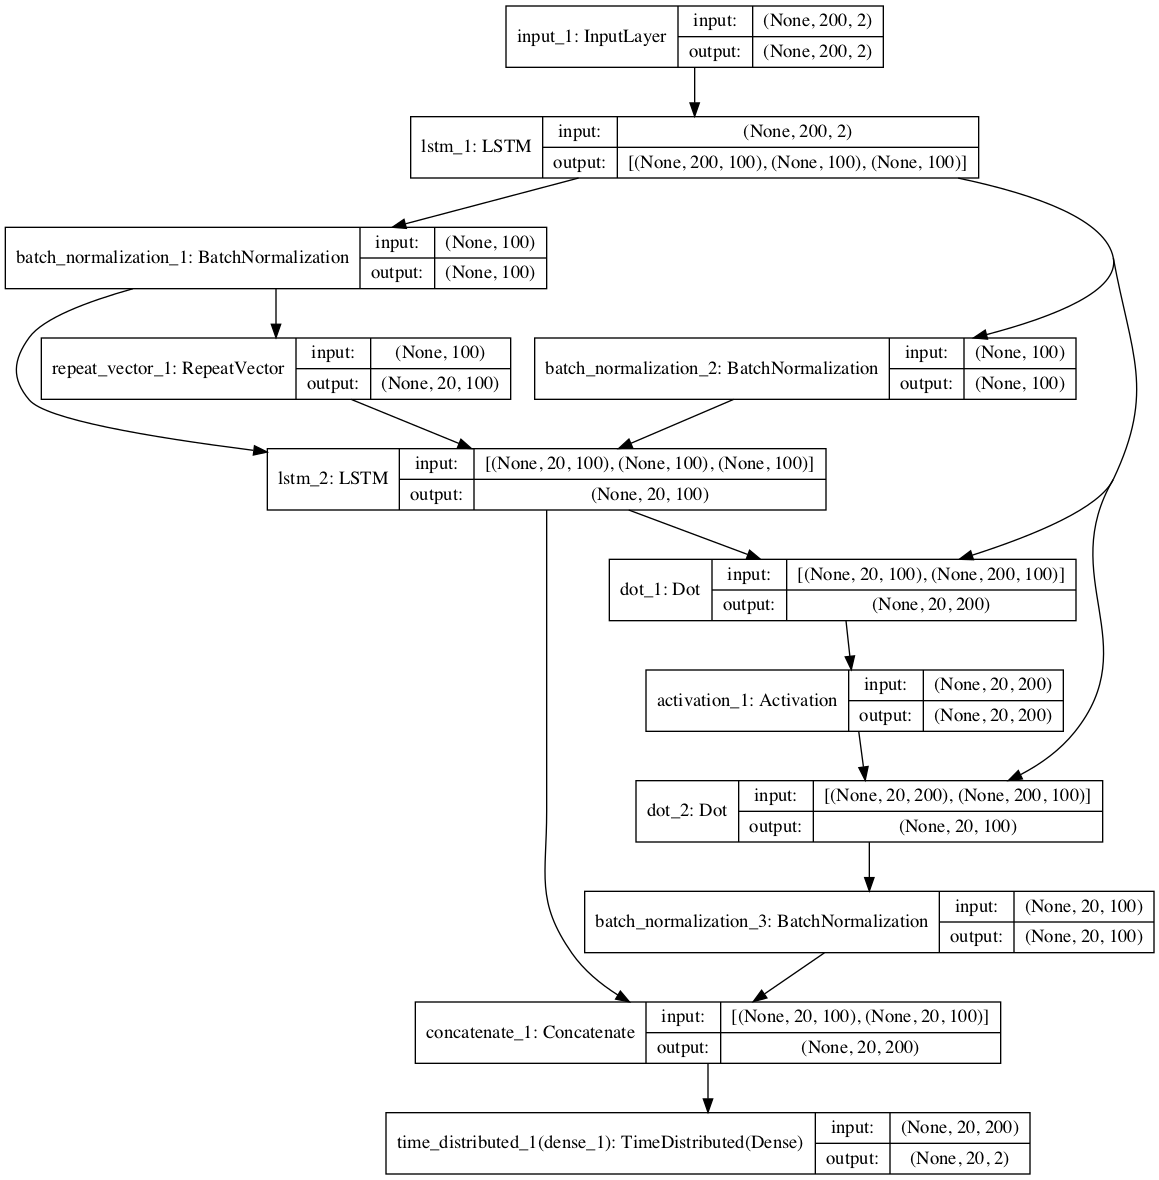

In [15]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [16]:
epc = 100
es = EarlyStopping(monitor='val_loss', mode='min', patience=50)
history = model.fit(X_input_train[:, :, :2], X_output_train[:, :, :2], validation_split=0.2, 
                    epochs=epc, verbose=1, callbacks=[es], 
                    batch_size=100)
train_mae = history.history['mae']
valid_mae = history.history['val_mae']

model.save('model_forecasting_seq2seq_attention.h5')

Train on 480 samples, validate on 120 samples
Epoch 1/100
480/480 [==============================] - 4s 8ms/step - loss: 4.2157 - mae: 0.9690 - val_loss: 0.1432 - val_mae: 0.2704
Epoch 2/100
480/480 [==============================] - 2s 5ms/step - loss: 0.1956 - mae: 0.3375 - val_loss: 0.1408 - val_mae: 0.2733
Epoch 3/100
480/480 [==============================] - 2s 4ms/step - loss: 0.1513 - mae: 0.2920 - val_loss: 0.1265 - val_mae: 0.2575
Epoch 4/100
480/480 [==============================] - 2s 4ms/step - loss: 0.1399 - mae: 0.2782 - val_loss: 0.1206 - val_mae: 0.2561
Epoch 5/100
480/480 [==============================] - 2s 4ms/step - loss: 0.1324 - mae: 0.2706 - val_loss: 0.1134 - val_mae: 0.2456
Epoch 6/100
480/480 [==============================] - 2s 4ms/step - loss: 0.1253 - mae: 0.2627 - val_loss: 0.1034 - val_mae: 0.2363
Epoch 7/100
480/480 [==============================] - 2s 4ms/step - loss: 0.1195 - mae: 0.2573 - val_loss: 0.1113 - val_mae: 0.2468
Epoch 8/100
480/480 [==

Epoch 62/100
480/480 [==============================] - 2s 5ms/step - loss: 0.0340 - mae: 0.1348 - val_loss: 0.0161 - val_mae: 0.0972
Epoch 63/100
480/480 [==============================] - 2s 4ms/step - loss: 0.0323 - mae: 0.1311 - val_loss: 0.0170 - val_mae: 0.1002
Epoch 64/100
480/480 [==============================] - 2s 4ms/step - loss: 0.0385 - mae: 0.1406 - val_loss: 0.0218 - val_mae: 0.1139
Epoch 65/100
480/480 [==============================] - 2s 4ms/step - loss: 0.0389 - mae: 0.1420 - val_loss: 0.0209 - val_mae: 0.1098
Epoch 66/100
480/480 [==============================] - 2s 4ms/step - loss: 0.0378 - mae: 0.1391 - val_loss: 0.0165 - val_mae: 0.0991
Epoch 67/100
480/480 [==============================] - 2s 4ms/step - loss: 0.0338 - mae: 0.1333 - val_loss: 0.0150 - val_mae: 0.0951
Epoch 68/100
480/480 [==============================] - 2s 4ms/step - loss: 0.0334 - mae: 0.1315 - val_loss: 0.0131 - val_mae: 0.0910
Epoch 69/100
480/480 [==============================] - 2s 4ms

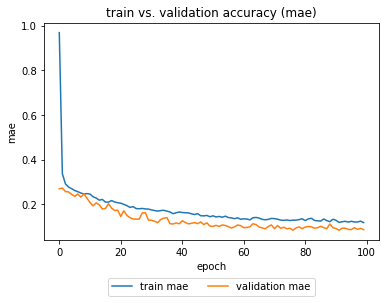

In [17]:
plt.plot(train_mae, label='train mae'), 
plt.plot(valid_mae, label='validation mae')
plt.ylabel('mae')
plt.xlabel('epoch')
plt.title('train vs. validation accuracy (mae)')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
plt.show()

# Predict

In [18]:
train_pred_detrend = model.predict(X_input_train[:, :, :2])*x_train_max[:2]
test_pred_detrend = model.predict(X_input_test[:, :, :2])*x_train_max[:2]
print(train_pred_detrend.shape, test_pred_detrend.shape)

train_true_detrend = X_output_train[:, :, :2]*x_train_max[:2]
test_true_detrend = X_output_test[:, :, :2]*x_train_max[:2]
print(train_true_detrend.shape, test_true_detrend.shape)

(600, 20, 2) (181, 20, 2)
(600, 20, 2) (181, 20, 2)


In [19]:
# combine with the index
train_pred_detrend = np.concatenate([train_pred_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_pred_detrend = np.concatenate([test_pred_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

train_true_detrend = np.concatenate([train_true_detrend, np.expand_dims(X_output_train[:, :, 2], axis=2)], axis=2)
test_true_detrend = np.concatenate([test_true_detrend, np.expand_dims(X_output_test[:, :, 2], axis=2)], axis=2)
print(train_pred_detrend.shape, test_pred_detrend.shape)

(600, 20, 3) (181, 20, 3)
(600, 20, 3) (181, 20, 3)


In [20]:
# recover trend
data_final = dict()

for dt, lb in zip([train_pred_detrend, train_true_detrend, test_pred_detrend, test_true_detrend], 
                  ['train_pred', 'train_true', 'test_pred', 'test_true']):
    dt_x1 = dt[:, :, 0] + (dt[:, :, 2]**2)*x1_trend_param[0] + dt[:, :, 2]*x1_trend_param[1] + x1_trend_param[2]
    dt_x2 = dt[:, :, 1] + dt[:, :, 2]*x2_trend_param[0] + x2_trend_param[1]
    data_final[lb] = np.concatenate(
        [np.expand_dims(dt_x1, axis=2), np.expand_dims(dt_x2, axis=2)], axis=2)
    print(lb+': {}'.format(data_final[lb].shape))


train_pred: (600, 20, 2)
train_true: (600, 20, 2)
test_pred: (181, 20, 2)
test_true: (181, 20, 2)


In [21]:
for k in ['train_pred', 'train_true', 'test_pred', 'test_true']:
    print('maximum: {}'.format(k))
    print(data_final[k].max())

maximum: train_pred
223.58452974622037
maximum: train_true
224.61373469126457
maximum: test_pred
312.5558301799434
maximum: test_true
307.0617184410105


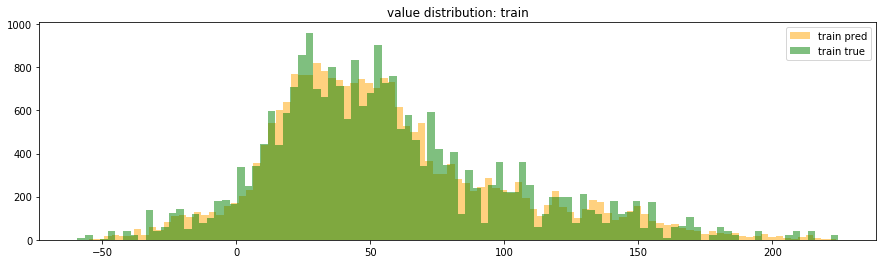

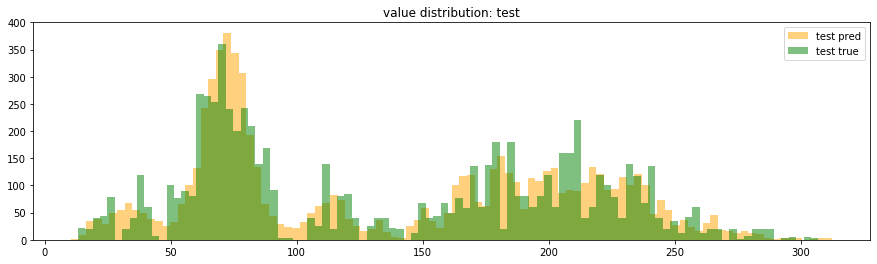

In [22]:
for lb in ['train', 'test']:
    plt.figure(figsize=(15, 4))
    plt.hist(data_final[lb+'_pred'].flatten(), bins=100, color='orange', alpha=0.5, label=lb+' pred')
    plt.hist(data_final[lb+'_true'].flatten(), bins=100, color='green', alpha=0.5, label=lb+' true')
    plt.legend()
    plt.title('value distribution: '+lb)
    plt.show()

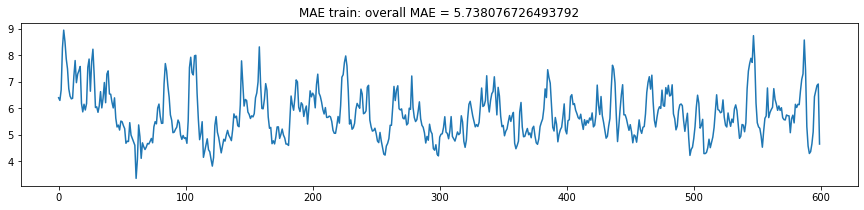

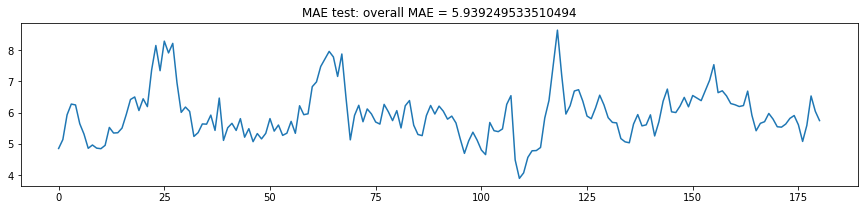

In [23]:
for lb in ['train', 'test']:
    MAE_overall = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean()
    MAE_ = abs(data_final[lb+'_pred'] - data_final[lb+'_true']).mean(axis=(1, 2))
    plt.figure(figsize=(15, 3))
    plt.plot(MAE_)
    plt.title('MAE '+lb+': overall MAE = '+str(MAE_overall))
    plt.show() 

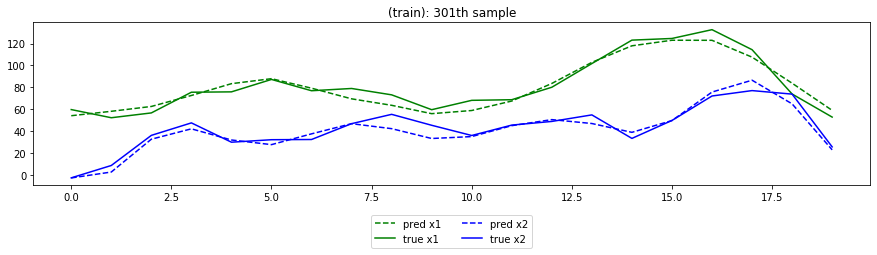

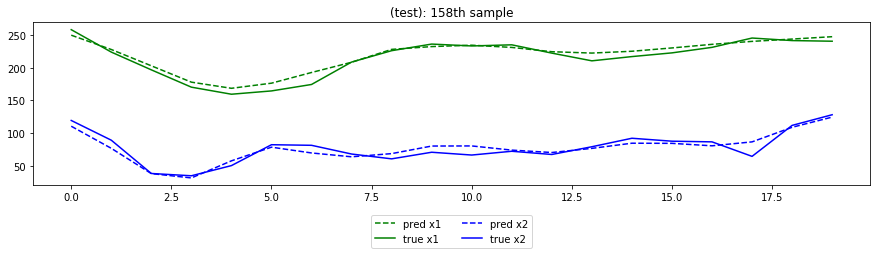

In [34]:
for lb in ['train', 'test']:
    ith_sample = random.choice(range(data_final[lb+'_pred'].shape[0]))
    plt.figure(figsize=(15,3))
    for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
        plt.plot(data_final[lb+'_pred'][ith_sample, :, i], linestyle='--', color=clr, label='pred '+x_lbl)
        plt.plot(data_final[lb+'_true'][ith_sample, :, i], linestyle='-', color=clr, label='true '+x_lbl)
    plt.title('({}): {}th sample'.format(lb, ith_sample))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
    plt.show()

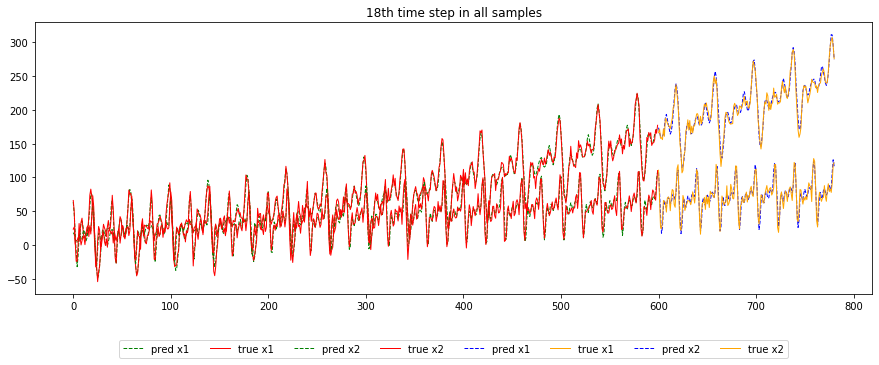

In [40]:
ith_timestep = random.choice(range(data_final[lb+'_pred'].shape[1]))
plt.figure(figsize=(15, 5))
train_start_t = 0
test_start_t = data_final['train_pred'].shape[0]
for lb, tm, clrs in zip(['train', 'test'], [train_start_t, test_start_t], [['green', 'red'], ['blue', 'orange']]):
    for i, x_lbl in zip([0, 1], ['x1', 'x2']):
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_pred'][:, ith_timestep, i], 
                 linestyle='--', linewidth=1, color=clrs[0], label='pred '+x_lbl)
        plt.plot(range(tm, tm+data_final[lb+'_pred'].shape[0]), 
                 data_final[lb+'_true'][:, ith_timestep, i], 
                 linestyle='-', linewidth=1, color=clrs[1], label='true '+x_lbl)
    
    
plt.title('{}th time step in all samples'.format(ith_timestep))
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=8)
plt.show()

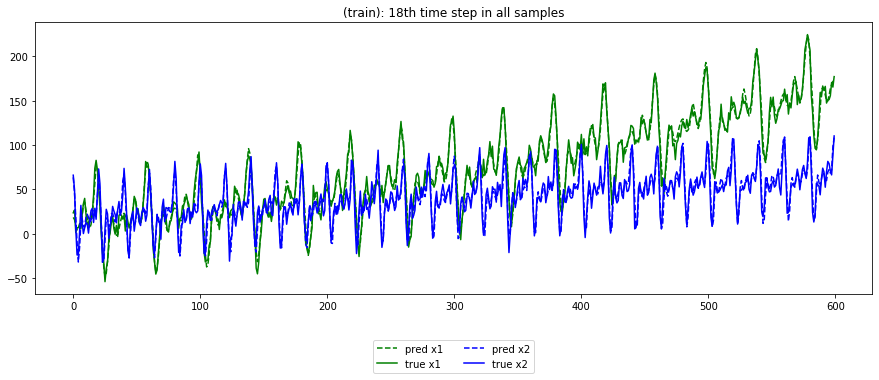

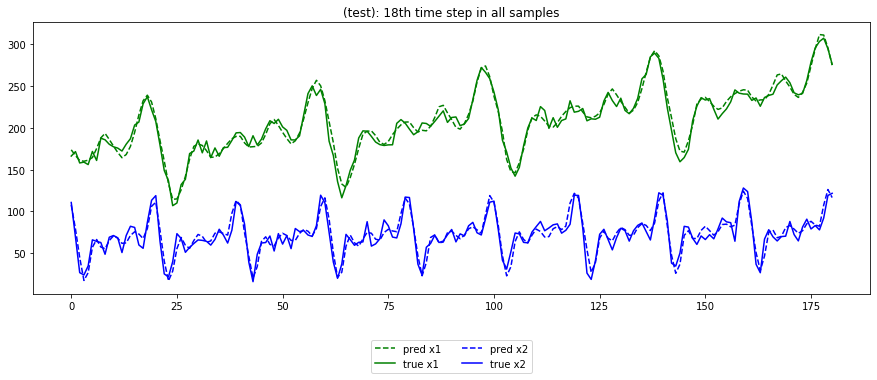

In [41]:
for lb in ['train', 'test']:
    plt.figure(figsize=(15, 5))
    for i, x_lbl, clr in zip([0, 1], ['x1', 'x2'], ['green', 'blue']):
        plt.plot(data_final[lb+'_pred'][:, ith_timestep, i], linestyle='--', color=clr, label='pred '+x_lbl)
        plt.plot(data_final[lb+'_true'][:, ith_timestep, i], linestyle='-', color=clr, label='true '+x_lbl)
    plt.title('({}): {}th time step in all samples'.format(lb, ith_timestep))
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), fancybox=True, shadow=False, ncol=2)
    plt.show()
